In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
df = pd.read_csv('friday.csv', delimiter=";")
for csv in os.listdir():
    if csv[-3:] == "csv":                
        df_day = pd.read_csv(f'{csv}', delimiter=";")
        df = pd.concat([df, df_day], sort=True)


In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['weekday'].replace({0:'Mon',1:'Tues', 2:'Wednes',3:'Thurs',4:'Fri'}, inplace=True)

In [6]:
df.head(900)

,customer_no,location,timestamp,hour,weekday
0,1,dairy,2019-09-06 07:00:00,7,Fri
1,2,drinks,2019-09-06 07:00:00,7,Fri
2,3,fruit,2019-09-06 07:00:00,7,Fri
3,2,checkout,2019-09-06 07:01:00,7,Fri
4,4,drinks,2019-09-06 07:01:00,7,Fri
...,...,...,...,...,...
895,267,dairy,2019-09-06 09:21:00,9,Fri
896,269,dairy,2019-09-06 09:21:00,9,Fri
897,261,dairy,2019-09-06 09:22:00,9,Fri
898,267,checkout,2019-09-06 09:22:00,9,Fri


### Calculate the total number of customers in each section

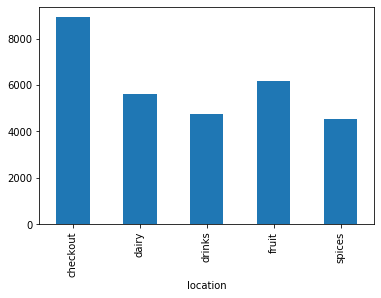

In [7]:
df.groupby('location')['customer_no'].count().plot.bar()

<Figure size 864x576 with 0 Axes>

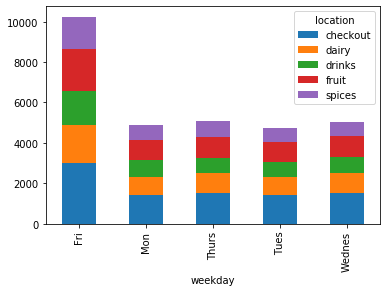

In [57]:
df_w_sec = df.groupby(['weekday','location'])['customer_no'].count()
plt.figure(figsize=(12,8))
df_w_sec.unstack().plot.bar(stacked=True
                           )

### Calculate the total number of customers in each section and at checkout over time

In [9]:
import seaborn as sns

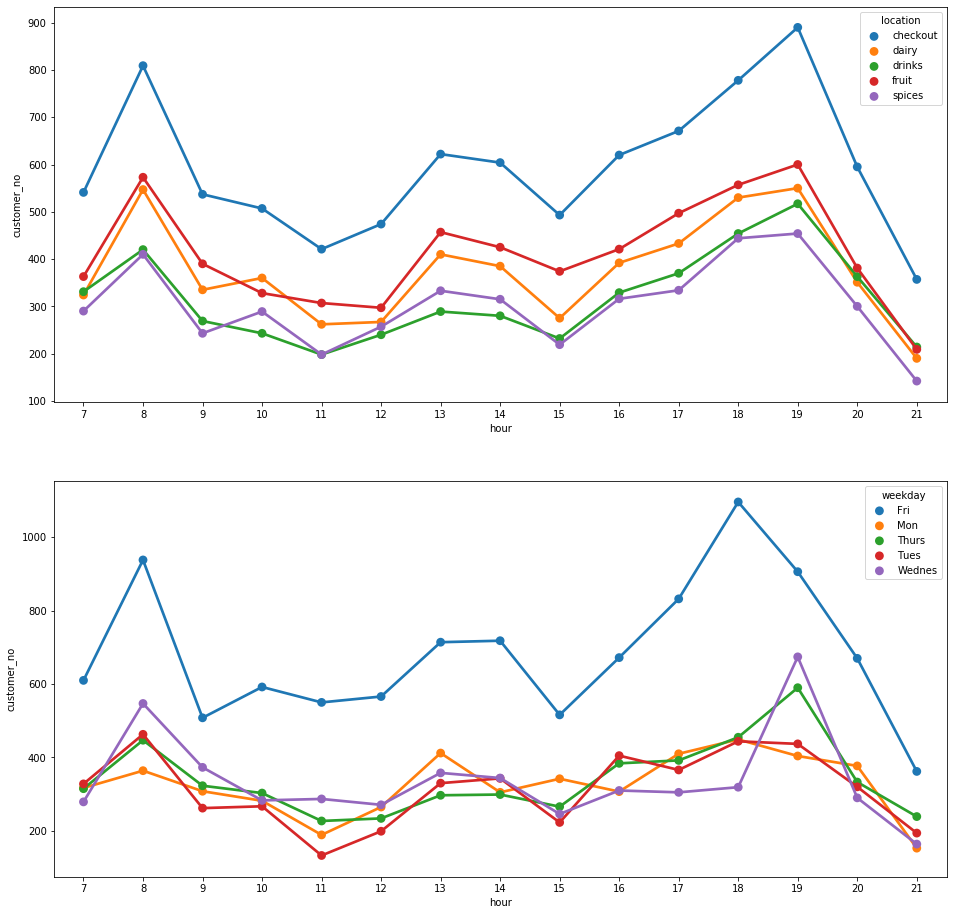

In [10]:
df_o_loc = df.groupby(['location','hour'], sort=True)['customer_no'].count().reset_index()
df_o_total = df.groupby(['weekday','hour'], sort=True)['customer_no'].count().reset_index()


plt.figure(figsize=(16,16))

plt.subplot(2,1,1)
sns.pointplot(x=df_o_loc["hour"], y=df_o_loc["customer_no"], hue=df_o_loc["location"], data=df_o_loc, join=True)

plt.subplot(2,1,2)
sns.pointplot(x=df_o_total["hour"], y=df_o_total["customer_no"], hue=df_o_total["weekday"], data=df_o_total, join=True)



### Calculate the time each customer spent in the market

In [11]:
enter = df.sort_values("customer_no").groupby(['customer_no','weekday'])['timestamp'].max()
out = df.sort_values("customer_no").groupby(['customer_no','weekday'])['timestamp'].min()

In [12]:
time_spent = enter - out

In [13]:
time_spent = time_spent.unstack()
time_spent = time_spent.unstack()


In [14]:
time_spent = pd.DataFrame(time_spent, columns=["timespent"])
time_spent

timespent
weekday customer_no          
Fri     1            00:05:00
        2            00:01:00
        3            00:11:00
        4            00:01:00
        5            00:14:00
...                       ...
Wednes  1531         00:03:00
        1532              NaT
        1533              NaT
        1534              NaT
        1535              NaT

[7675 rows x 1 columns]

### Time spent at each aisle

In [25]:
def time_spent_each_aisle(aisle):
    
    df_sec_time = pd.DataFrame(df.sort_values(['customer_no','timestamp']).groupby(['weekday','customer_no','location'])['timestamp'].min())
    df_sec_time = df_sec_time.sort_values(["customer_no",'timestamp'])
    df_sec_time= pd.DataFrame(df_sec_time.index.get_level_values(2), df_sec_time['timestamp']).reset_index()
    df_sec_time['timestamp-2'] = df_sec_time['timestamp'].shift(-1)

    df_sec_time = df_sec_time[df_sec_time['location'] == aisle]
    df_sec_time ['timespent'] = df_sec_time ['timestamp-2'] - df_sec_time['timestamp']
    df_sec_time = df_sec_time[(df_sec_time['timespent']< pd.to_timedelta('40m')) & (df_sec_time['timespent'] >= pd.to_timedelta('1m'))]
    total_minutes = sum(df_sec_time['timespent']/pd.Timedelta('1 min'))
    return total_minutes


In [42]:
aisles = ['fruit', 'spices', 'drinks', 'dairy']
rev_per_min = [4, 3, 5, 6]
total_min =[]
for a in aisles:
    t = time_spent_each_aisle(a)
    total_min.append(t)
    


In [36]:
total_min

[12536.0, 7783.0, 9775.0, 16344.0]

In [51]:
df_money = pd.DataFrame(columns=['aisle', 'time_spent(minutes)'])
df_money['aisle'] = aisles
df_money['time_spent(minutes)'] = total_min
df_money['rev_per_min'] = rev_per_min
df_money['total income'] = df_money['time_spent(minutes)'] * df_money['rev_per_min'] 
df_money

,aisle,time_spent(minutes),rev_per_min,total income
0,fruit,12536.0,4,50144.0
1,spices,7783.0,3,23349.0
2,drinks,9775.0,5,48875.0
3,dairy,16344.0,6,98064.0
